In [1]:
import pandas as pd
import json

In [10]:
over_methods = [
    "adasyn", "ctgan", "copulagan", "fastml",
    "gaussiancopula", "random", "smote", "tvae"
]

under_methods =["random"]

over_thresh = [0, 0.25, 0.5, 1, 5, "auto"]
under_thresh = [0, 0.05, 0.1, 0.2, 0.3, "auto"]
dataset_name = "openml_44"
target = "class"
continuous_columns = ["col_0", "col_1", "col_2", "col_3", "col_4", "col_5"]

n_continuous = len(continuous_columns)

dataset_path = "./datasets/"
results_path = "./results/"
metrics_path = "./metrics/"

# Results template
# f"openml_23-u_{u_method}_{u_thresh}-o_{o_method}_{o_thresh}"

## Columns score

In [ ]:
from data_augmentation.metrics.sdv_metrics import evaluate_single_columns, evaluate_pairs_columns
from data_augmentation.metrics.pca import get_explained_variance_ratio, get_n_components,fit_pca

In [ ]:
columns_metrics = pd.DataFrame()

original_data = pd.read_csv(dataset_path+dataset_name+".csv")
n_discrete = len(original_data.columns) - len(continuous_columns)
x_col = [col for col in original_data.columns if col != target]
n_components = get_n_components(original_data[x_col], 0.95)
original_pca = fit_pca(original_data[x_col], n_components)
original_evr = get_explained_variance_ratio(original_pca)

for u_method in under_methods:
    for u_thresh in under_thresh:
        for o_method in over_methods:
            for o_thresh in over_thresh:

                result_dataset_name = f"{dataset_name}-u_{u_method}_{u_thresh}-o_{o_method}_{o_thresh}"
                print(result_dataset_name)

                # READING DATASET
                try:
                    result_data = pd.read_csv(results_path+result_dataset_name+".csv")
                except:
                    result_data = pd.DataFrame()

                # EVALUATING SINGLE COLUMN SCORE
                try:
                    score = evaluate_single_columns(
                        original_data, result_data, target, continuous_columns
                    )
                    single_column_score = (score["ks"] * n_continuous + score["tv"] * n_discrete)/(n_continuous + n_discrete)
                except:
                    single_column_score = 0

                # EVALUATING MULTIPLE COLUMNS SCORE
                try:
                    score = evaluate_pairs_columns(
                        original_data, result_data, target, continuous_columns
                    )
                    column_pairs_score = (score["correlation"] * n_continuous + score["contingency"] * n_discrete)/(n_continuous + n_discrete)
                except:
                    column_pairs_score = 0

                # EVALUATING PCA
                try:
                    generated_pca = fit_pca(result_data[x_col], n_components)
                    generated_evr = get_explained_variance_ratio(generated_pca)
                    diff_pca = generated_evr - original_evr
                except:
                    diff_pca = 0 - original_evr

                metrics = pd.DataFrame({
                    "under_method": [u_method],
                    "under_thresh": [u_thresh],
                    "over_method": [o_method],
                    "over_thresh": [o_thresh],
                    "single_column": [single_column_score],
                    "pairs_columns": [column_pairs_score],
                    "diff_pca": [diff_pca],
                })

                columns_metrics = pd.concat([columns_metrics, metrics], axis=0)

In [ ]:
columns_metrics.reset_index(inplace=True, drop=True)
columns_metrics.to_csv(results_path+dataset_name+"_metrics.csv", index=False)

In [ ]:
columns_metrics

## Modelling metrics

In [11]:
model_metrics = pd.DataFrame()

for u_method in under_methods:
    for u_thresh in under_thresh:
        for o_method in over_methods:
            for o_thresh in over_thresh:

                result_dataset_name = f"{dataset_name}-u_{u_method}_{u_thresh}-o_{o_method}_{o_thresh}"
                print(result_dataset_name)

                # READING metrics
                try:
                    with open(metrics_path+result_dataset_name+".json", "r") as fp:
                        _metrics = json.load(fp)
                    result_data = pd.DataFrame([_metrics])
                except Exception as e:
                    print(e)
                    result_data = pd.DataFrame()

                result_data["under_method"] = u_method
                result_data["under_thresh"] = u_thresh
                result_data["over_method"] = o_method
                result_data["over_thresh"] = o_thresh
                model_metrics = pd.concat([model_metrics, result_data], axis=0)

openml_44-u_random_0-o_adasyn_0
openml_44-u_random_0-o_adasyn_0.25
openml_44-u_random_0-o_adasyn_0.5
openml_44-u_random_0-o_adasyn_1
openml_44-u_random_0-o_adasyn_5
openml_44-u_random_0-o_adasyn_auto
openml_44-u_random_0-o_ctgan_0
openml_44-u_random_0-o_ctgan_0.25
openml_44-u_random_0-o_ctgan_0.5
openml_44-u_random_0-o_ctgan_1
openml_44-u_random_0-o_ctgan_5
openml_44-u_random_0-o_ctgan_auto
openml_44-u_random_0-o_copulagan_0
openml_44-u_random_0-o_copulagan_0.25
openml_44-u_random_0-o_copulagan_0.5
openml_44-u_random_0-o_copulagan_1
openml_44-u_random_0-o_copulagan_5
openml_44-u_random_0-o_copulagan_auto
openml_44-u_random_0-o_fastml_0
openml_44-u_random_0-o_fastml_0.25
openml_44-u_random_0-o_fastml_0.5
openml_44-u_random_0-o_fastml_1
openml_44-u_random_0-o_fastml_5
openml_44-u_random_0-o_fastml_auto
openml_44-u_random_0-o_gaussiancopula_0
openml_44-u_random_0-o_gaussiancopula_0.25
openml_44-u_random_0-o_gaussiancopula_0.5
openml_44-u_random_0-o_gaussiancopula_1
openml_44-u_random_0-o_

In [12]:
model_metrics.reset_index(inplace=True, drop=True)
model_metrics.to_csv(results_path+dataset_name+"_model_metrics.csv", index=False)

## Plots

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

In [6]:
def plot_metric(dataset, metric_name, vmin, vmax, save):

    unique_u_methods = dataset["under_method"].unique()
    unique_o_methods = dataset["over_method"].unique()

    unique_u_methods.sort()
    unique_o_methods.sort()

    n_plots = len(unique_u_methods) * len(unique_o_methods)
    n_cols = 4
    n_rows = math.ceil(n_plots / n_cols)

    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(24, 12))

    i, j = 0, 0
    for u_method in unique_u_methods:
        for o_method in unique_o_methods:
            sliced_data = dataset.loc[dataset["under_method"] == u_method, :]
            sliced_data = sliced_data.loc[sliced_data["over_method"] == o_method, :]

            pv_table = pd.pivot_table(sliced_data, metric_name, "under_thresh", "over_thresh")
            cp_pv_table = pv_table.copy()
            for idx_pv, idx_inv in zip(cp_pv_table.index, cp_pv_table.index[::-1]):
                pv_table.loc[idx_pv, :] = cp_pv_table.loc[idx_inv]
            pv_table.set_index(cp_pv_table.index[::-1], drop=True, inplace=True)

            u_thresh = [str(n) for n in pv_table.index]
            o_thresh = [str(n) for n in pv_table.columns]

            if j >= n_cols:
                j=0
                i+=1

            if vmin and vmax:
                ax[i][j].imshow(pv_table, cmap="Reds", vmin=vmin, vmax=vmax)
            else:
                ax[i][j].imshow(pv_table, cmap="Reds")
            ax[i][j].set_xticks(np.arange(len(o_thresh)), labels=o_thresh)
            ax[i][j].set_yticks(np.arange(len(u_thresh)), labels=u_thresh)
            for k in range(len(u_thresh)):
                for w in range(len(o_thresh)):
                    text = ax[i][j].text(w, k, f"{pv_table.iloc[k, w]:.3f}",
                                ha="center", va="center", color="w")

            ax[i][j].set_title(metric_name)
            ax[i][j].set_xlabel(f"Oversampling: {o_method}")
            ax[i][j].set_ylabel(f"Undersampling: {u_method}")
            j+=1

    if save:
        plt.savefig(save)
    plt.show()

In [ ]:
plot_metric(columns_metrics, "single_column", 0.9, 1, save=f"./report/{dataset_name}_single_column.png")

In [ ]:
plot_metric(columns_metrics, "pairs_columns", 0.9, 1, save=f"./report/{dataset_name}_pairs_columns.png")

In [ ]:
plot_metric(columns_metrics, "diff_pca", 0, 0, save=f"./report/{dataset_name}_diff_pca.png")

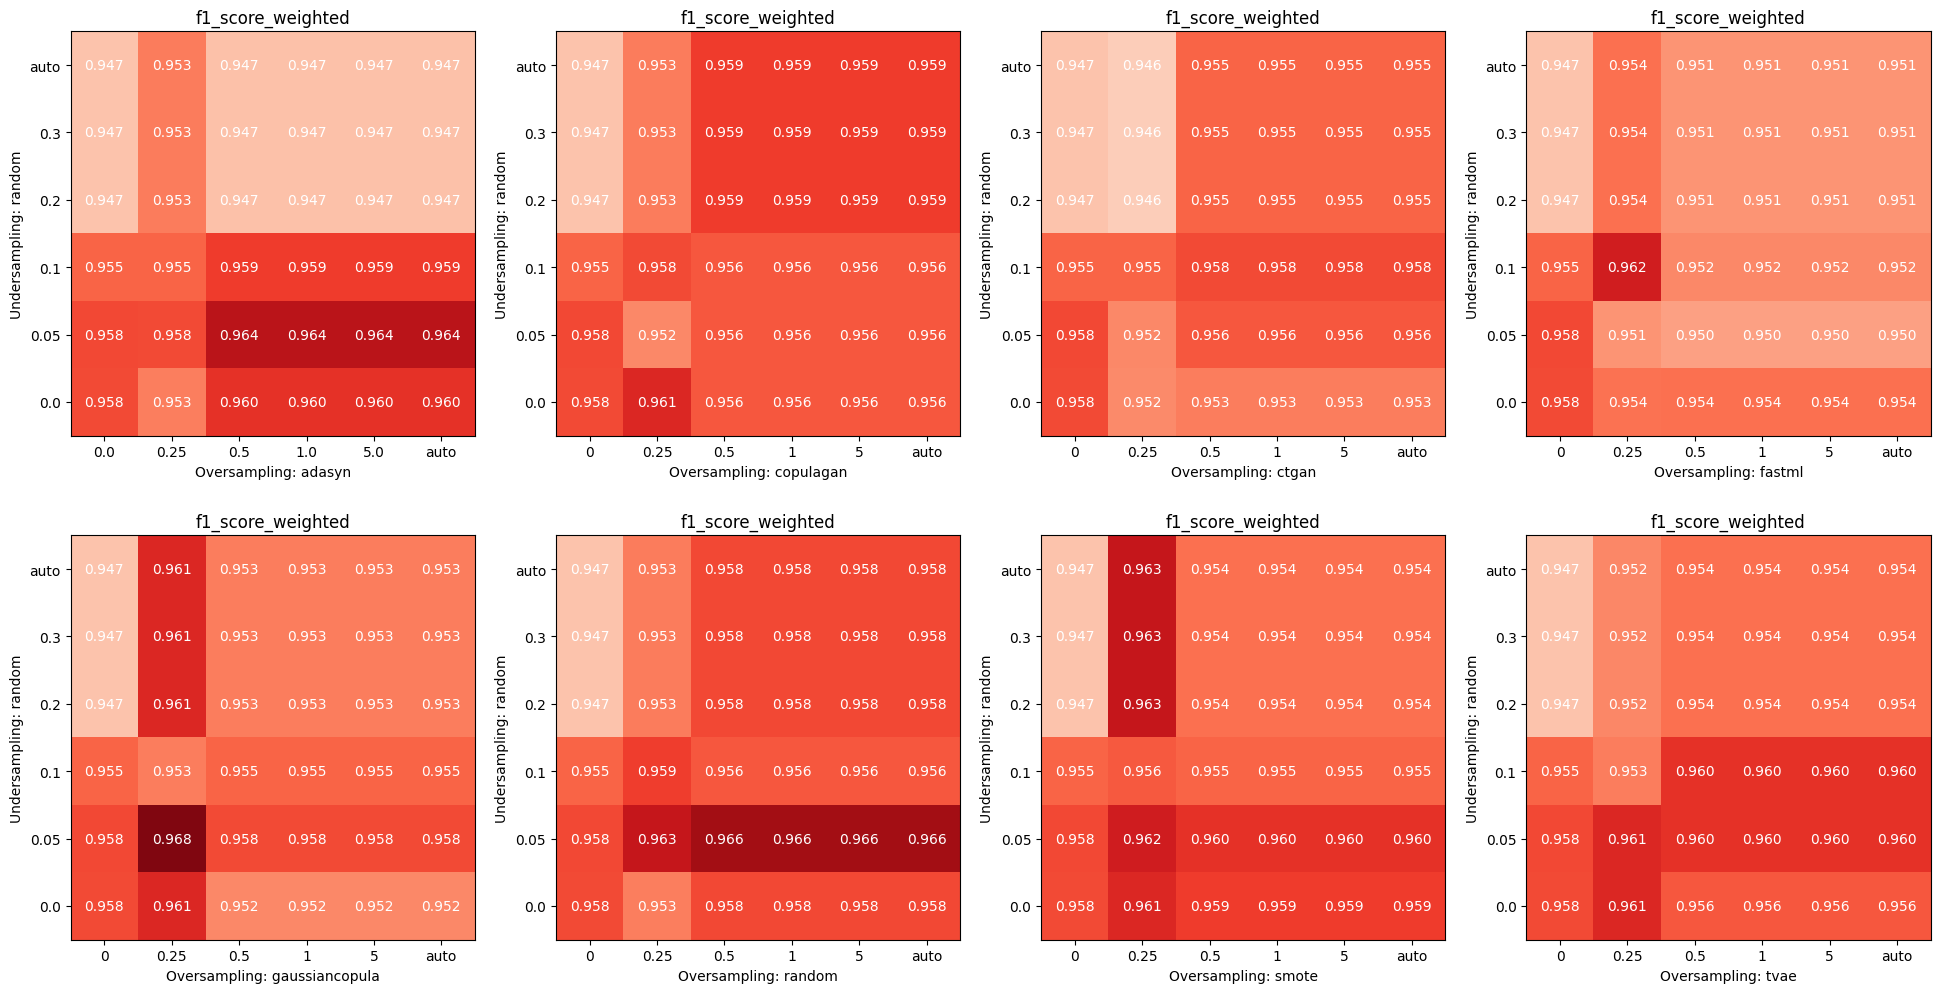

In [15]:
plot_metric(model_metrics, "f1_score_weighted", 0.94, 0.97, save=f"./report/{dataset_name}_f1_score_weighted.png")

In [14]:
model_metrics["f1_score_weighted"].describe()

count    288.000000
mean       0.954951
std        0.004530
min        0.945653
25%        0.953178
50%        0.955427
75%        0.957585
max        0.968461
Name: f1_score_weighted, dtype: float64